# MONAI : Tutorial : modules
## GAN Workflow Engine with the MedNIST Dataset

参照URL:
- https://github.com/Project-MONAI/tutorials/blob/main/modules/mednist_GAN_workflow_dict.ipynb
- https://www.classcat.com/medical_ai/2022/11/13/monai-1-0-tutorials-modules-mednist-gan-workflow-dict/

ステップ:
- セットアップ
- MONAIコンポーネントの初期化
  - 画像変換チェーン作成
  - データセット, データローダ作成
  - Generator, Discriminator定義
  - 学習ハンドラ作成
  - GANトレーナー作成
- 学習の実行
- 結果の評価

## 0. 準備

In [1]:
# パッケージのインストール
#!python -c "import monai" || pip install -q "monai-weekly[ignite, tqdm]"
#!python -c 2import matplotlib" || pip install -q matplotlib

In [2]:
# パッケージのインポート
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.engines import GanTrainer
from monai.engines.utils import GanKeys, default_make_latent
from monai.handlers import CheckpointSaver, MetricLogger, StatsHandler
from monai.networks import normal_init
from monai.networks.nets import Discriminator, Generator
from monai.transforms import (
    AddChannelD,
    Compose,
    LoadImageD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityD,
    EnsureTypeD,
)
from monai.utils import set_determinism


In [3]:
# データディレクトリ
root_dir = './data'
print(root_dir)

./data


In [4]:
# データのダウンロード
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, 'MedNIST.tar.gz')
data_dir = os.path.join(root_dir, 'MedNIST')
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [5]:
hand_dir = os.path.join(data_dir, 'Hand')
training_datadict = [
    {'hand': os.path.join(hand_dir, filename)}
    for filename in os.listdir(hand_dir)
]

## 1. MONAIコンポーネントの初期化

In [6]:
# 乱数シードの設定
set_determinism(2023)

In [7]:
# CUDAチェック
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1.1 画像変換チェーン作成

In [8]:
train_transforms = Compose(
    [
        LoadImageD(keys=['hand']),
        AddChannelD(keys=['hand']),
        ScaleIntensityD(keys=['hand']),
        RandRotateD(keys=['hand'], range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlipD(keys=['hand'], spatial_axis=0, prob=0.5),
        RandZoomD(keys=['hand'], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureTypeD(keys=['hand']),
    ]
)

/home/akira/venv/monai/lib/python3.7/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


### 1.2 データセット, データローダ作成

In [9]:
real_dataset = CacheDataset(training_datadict, transform=train_transforms)

batch_size = 300

real_dataloader = DataLoader(real_dataset, batch_size=batch_size, shuffle=True, num_workers=10)

Loading dataset: 100%|██████████████████| 10000/10000 [00:09<00:00, 1078.57it/s]


In [10]:
def prepare_batch(batchdata, device=None, non_blocking=False):
    return batchdata['hand'].to(device=device, non_blocking=non_blocking)

### 1.3 Generator, Discriminator定義

In [11]:
# define networks
disc_net = Discriminator(
    in_shape=(1, 64, 64),
    channels=(8, 16, 32, 64, 1),
    strides=(2, 2, 2, 2, 1),
    num_res_units=1,
    kernel_size=5,
).to(device)

In [12]:
latent_size = 64

gen_net = Generator(
    latent_shape=latent_size,
    start_shape=(latent_size, 8, 8),
    channels=(32, 16, 8, 1),
    strides=(2, 2, 2, 1),
)

gen_net.conv.add_module('activation', torch.nn.Sigmoid())
gen_net = gen_net.to(device)

In [13]:
# initialize both networks
disc_net.apply(normal_init)
gen_net.apply(normal_init)

Generator(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=64, out_features=4096, bias=True)
  (reshape): Reshape()
  (conv): Sequential(
    (layer_0): Sequential(
      (0): Convolution(
        (conv): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      )
      (1): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (adn): ADN(
              (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (adn): ADN(
              (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (A): PReLU(num_parameters=1)
   

In [14]:
# define optimizors
learning_rate = 2e-4
betas = (0.5, 0.999)
disc_opt = torch.optim.Adam(disc_net.parameters(), learning_rate, betas=betas)
gen_opt = torch.optim.Adam(gen_net.parameters(), learning_rate, betas=betas)

In [15]:
# define loss functions
disc_loss_criterion = torch.nn.BCELoss()
gen_loss_criterion = torch.nn.BCELoss()
real_label = 1
fake_label = 0

In [16]:
def discriminator_loss(gen_images, real_images):
    real = real_images.new_full((real_images.shape[0], 1), real_label)
    gen = gen_images.new_full((gen_images.shape[0], 1), fake_label)
    
    realloss = disc_loss_criterion(disc_net(real_images), real)
    genloss = disc_loss_criterion(disc_net(gen_images.detach()), gen)
    
    return (genloss + realloss) / 2

def generator_loss(gen_images):
    output = disc_net(gen_images)
    cats = output.new_full(output.shape, real_label)
    return gen_loss_criterion(output, cats)

### 1. 4 学習ハンドラ作成

In [17]:
metric_logger = MetricLogger(
    loss_transform=lambda x: {
        GanKeys.GLOSS: x[GanKeys.GLOSS], 
        GanKeys.DLOSS: x[GanKeys.DLOSS]
    },
    metric_transform=lambda x: x,
)

handlers = [
    StatsHandler(
        name='batch_training_loss',
        output_transform=lambda x: {
            GanKeys.GLOSS: x[GanKeys.GLOSS],
            GanKeys.DLOSS: x[GanKeys.DLOSS],
        },
    ),
    CheckpointSaver(
        save_dir=os.path.join(root_dir, 'hand-gan'),
        save_dict={'g_net': gen_net, 'd_net': disc_net},
        save_interval=10,
        save_final=True,
        epoch_level=True,
    ),
    metric_logger,
]

### 1.5 Ganトレイナ作成

In [18]:
disc_train_steps = 5
max_epochs = 50

trainer = GanTrainer(
    device,
    max_epochs,
    real_dataloader,
    gen_net,
    gen_opt,
    generator_loss,
    disc_net,
    disc_opt,
    discriminator_loss,
    d_prepare_batch=prepare_batch,
    d_train_steps=disc_train_steps,
    g_update_latents=True,
    latent_shape=latent_size,
    key_train_metric=None,
    train_handlers=handlers,
)

## 2. 学習

In [19]:
trainer.run()

2023-01-30 14:18:48,606 - Engine run resuming from iteration 0, epoch 0 until 50 epochs
2023-01-30 14:18:52,867 - Epoch: 1/50, Iter: 1/34 -- d_loss: 3.2400 g_loss: 0.7763 
2023-01-30 14:18:53,123 - Epoch: 1/50, Iter: 2/34 -- d_loss: 2.5543 g_loss: 0.9934 
2023-01-30 14:18:53,394 - Epoch: 1/50, Iter: 3/34 -- d_loss: 1.6873 g_loss: 1.3659 
2023-01-30 14:18:53,648 - Epoch: 1/50, Iter: 4/34 -- d_loss: 0.9354 g_loss: 1.9341 
2023-01-30 14:18:53,972 - Epoch: 1/50, Iter: 5/34 -- d_loss: 0.4749 g_loss: 2.5962 
2023-01-30 14:18:54,218 - Epoch: 1/50, Iter: 6/34 -- d_loss: 0.2776 g_loss: 3.1525 
2023-01-30 14:18:54,437 - Epoch: 1/50, Iter: 7/34 -- d_loss: 0.1741 g_loss: 3.5229 
2023-01-30 14:18:54,653 - Epoch: 1/50, Iter: 8/34 -- d_loss: 0.1805 g_loss: 3.7432 
2023-01-30 14:18:54,859 - Epoch: 1/50, Iter: 9/34 -- d_loss: 0.1655 g_loss: 3.9192 
2023-01-30 14:18:55,062 - Epoch: 1/50, Iter: 10/34 -- d_loss: 0.2141 g_loss: 3.8652 
2023-01-30 14:18:55,284 - Epoch: 1/50, Iter: 11/34 -- d_loss: 0.1877 g_

2023-01-30 14:19:17,980 - Epoch: 3/50, Iter: 28/34 -- d_loss: 0.2496 g_loss: 4.0852 
2023-01-30 14:19:18,189 - Epoch: 3/50, Iter: 29/34 -- d_loss: 0.4068 g_loss: 3.6365 
2023-01-30 14:19:18,445 - Epoch: 3/50, Iter: 30/34 -- d_loss: 0.3746 g_loss: 3.8228 
2023-01-30 14:19:18,685 - Epoch: 3/50, Iter: 31/34 -- d_loss: 0.3311 g_loss: 4.0221 
2023-01-30 14:19:18,924 - Epoch: 3/50, Iter: 32/34 -- d_loss: 0.3591 g_loss: 4.0289 
2023-01-30 14:19:19,180 - Epoch: 3/50, Iter: 33/34 -- d_loss: 0.2667 g_loss: 4.0979 
2023-01-30 14:19:19,382 - Epoch: 3/50, Iter: 34/34 -- d_loss: 0.5084 g_loss: 3.5568 
2023-01-30 14:19:19,384 - Epoch[3] Complete. Time taken: 00:00:09.353
2023-01-30 14:19:21,045 - Epoch: 4/50, Iter: 1/34 -- d_loss: 0.3239 g_loss: 3.8101 
2023-01-30 14:19:21,298 - Epoch: 4/50, Iter: 2/34 -- d_loss: 0.2947 g_loss: 4.1861 
2023-01-30 14:19:21,502 - Epoch: 4/50, Iter: 3/34 -- d_loss: 0.3834 g_loss: 4.2585 
2023-01-30 14:19:21,707 - Epoch: 4/50, Iter: 4/34 -- d_loss: 0.4565 g_loss: 3.9713 

2023-01-30 14:19:44,542 - Epoch: 6/50, Iter: 21/34 -- d_loss: 0.4988 g_loss: 4.0770 
2023-01-30 14:19:44,778 - Epoch: 6/50, Iter: 22/34 -- d_loss: 0.6136 g_loss: 4.7532 
2023-01-30 14:19:44,997 - Epoch: 6/50, Iter: 23/34 -- d_loss: 0.5739 g_loss: 4.2515 
2023-01-30 14:19:45,236 - Epoch: 6/50, Iter: 24/34 -- d_loss: 0.5900 g_loss: 3.7719 
2023-01-30 14:19:45,465 - Epoch: 6/50, Iter: 25/34 -- d_loss: 0.7058 g_loss: 3.7399 
2023-01-30 14:19:45,711 - Epoch: 6/50, Iter: 26/34 -- d_loss: 0.4486 g_loss: 3.9821 
2023-01-30 14:19:45,975 - Epoch: 6/50, Iter: 27/34 -- d_loss: 0.4981 g_loss: 3.5378 
2023-01-30 14:19:46,190 - Epoch: 6/50, Iter: 28/34 -- d_loss: 0.6897 g_loss: 4.3626 
2023-01-30 14:19:46,410 - Epoch: 6/50, Iter: 29/34 -- d_loss: 0.4085 g_loss: 4.2036 
2023-01-30 14:19:46,626 - Epoch: 6/50, Iter: 30/34 -- d_loss: 0.5370 g_loss: 3.6185 
2023-01-30 14:19:47,018 - Epoch: 6/50, Iter: 31/34 -- d_loss: 0.5104 g_loss: 4.1630 
2023-01-30 14:19:47,242 - Epoch: 6/50, Iter: 32/34 -- d_loss: 0.5

2023-01-30 14:20:10,885 - Epoch: 9/50, Iter: 14/34 -- d_loss: 1.0582 g_loss: 2.8087 
2023-01-30 14:20:11,072 - Epoch: 9/50, Iter: 15/34 -- d_loss: 1.0029 g_loss: 2.7939 
2023-01-30 14:20:11,277 - Epoch: 9/50, Iter: 16/34 -- d_loss: 0.9406 g_loss: 3.5670 
2023-01-30 14:20:11,520 - Epoch: 9/50, Iter: 17/34 -- d_loss: 0.9310 g_loss: 3.2761 
2023-01-30 14:20:11,735 - Epoch: 9/50, Iter: 18/34 -- d_loss: 0.8196 g_loss: 4.7453 
2023-01-30 14:20:11,949 - Epoch: 9/50, Iter: 19/34 -- d_loss: 0.9631 g_loss: 3.1842 
2023-01-30 14:20:12,205 - Epoch: 9/50, Iter: 20/34 -- d_loss: 1.8103 g_loss: 2.7900 
2023-01-30 14:20:12,636 - Epoch: 9/50, Iter: 21/34 -- d_loss: 1.7511 g_loss: 2.6816 
2023-01-30 14:20:12,861 - Epoch: 9/50, Iter: 22/34 -- d_loss: 1.2934 g_loss: 3.8349 
2023-01-30 14:20:13,140 - Epoch: 9/50, Iter: 23/34 -- d_loss: 0.7959 g_loss: 3.4800 
2023-01-30 14:20:13,407 - Epoch: 9/50, Iter: 24/34 -- d_loss: 0.8374 g_loss: 2.9894 
2023-01-30 14:20:13,630 - Epoch: 9/50, Iter: 25/34 -- d_loss: 1.0

2023-01-30 14:20:37,047 - Epoch: 12/50, Iter: 5/34 -- d_loss: 1.7610 g_loss: 2.6862 
2023-01-30 14:20:37,252 - Epoch: 12/50, Iter: 6/34 -- d_loss: 1.6466 g_loss: 3.4217 
2023-01-30 14:20:37,450 - Epoch: 12/50, Iter: 7/34 -- d_loss: 1.7175 g_loss: 2.7049 
2023-01-30 14:20:37,680 - Epoch: 12/50, Iter: 8/34 -- d_loss: 1.4621 g_loss: 1.9394 
2023-01-30 14:20:37,897 - Epoch: 12/50, Iter: 9/34 -- d_loss: 1.6287 g_loss: 2.0718 
2023-01-30 14:20:38,104 - Epoch: 12/50, Iter: 10/34 -- d_loss: 1.9222 g_loss: 2.0538 
2023-01-30 14:20:38,572 - Epoch: 12/50, Iter: 11/34 -- d_loss: 1.5424 g_loss: 2.5254 
2023-01-30 14:20:38,779 - Epoch: 12/50, Iter: 12/34 -- d_loss: 1.6016 g_loss: 2.2078 
2023-01-30 14:20:39,033 - Epoch: 12/50, Iter: 13/34 -- d_loss: 1.7774 g_loss: 2.0846 
2023-01-30 14:20:39,236 - Epoch: 12/50, Iter: 14/34 -- d_loss: 1.6879 g_loss: 2.1701 
2023-01-30 14:20:39,432 - Epoch: 12/50, Iter: 15/34 -- d_loss: 1.6094 g_loss: 1.9825 
2023-01-30 14:20:39,644 - Epoch: 12/50, Iter: 16/34 -- d_lo

2023-01-30 14:21:02,012 - Epoch: 14/50, Iter: 31/34 -- d_loss: 1.5603 g_loss: 2.4037 
2023-01-30 14:21:02,233 - Epoch: 14/50, Iter: 32/34 -- d_loss: 1.5344 g_loss: 2.1472 
2023-01-30 14:21:02,472 - Epoch: 14/50, Iter: 33/34 -- d_loss: 1.6626 g_loss: 2.0107 
2023-01-30 14:21:02,696 - Epoch: 14/50, Iter: 34/34 -- d_loss: 1.6874 g_loss: 2.0776 
2023-01-30 14:21:02,697 - Epoch[14] Complete. Time taken: 00:00:09.335
2023-01-30 14:21:04,216 - Epoch: 15/50, Iter: 1/34 -- d_loss: 1.4297 g_loss: 2.5358 
2023-01-30 14:21:04,625 - Epoch: 15/50, Iter: 2/34 -- d_loss: 1.5277 g_loss: 2.1572 
2023-01-30 14:21:04,810 - Epoch: 15/50, Iter: 3/34 -- d_loss: 1.8788 g_loss: 2.1715 
2023-01-30 14:21:05,017 - Epoch: 15/50, Iter: 4/34 -- d_loss: 2.1795 g_loss: 1.9425 
2023-01-30 14:21:05,224 - Epoch: 15/50, Iter: 5/34 -- d_loss: 1.6437 g_loss: 2.5111 
2023-01-30 14:21:05,454 - Epoch: 15/50, Iter: 6/34 -- d_loss: 1.6250 g_loss: 2.3325 
2023-01-30 14:21:05,652 - Epoch: 15/50, Iter: 7/34 -- d_loss: 1.4450 g_loss

2023-01-30 14:21:28,203 - Epoch: 17/50, Iter: 23/34 -- d_loss: 1.4592 g_loss: 2.4080 
2023-01-30 14:21:28,419 - Epoch: 17/50, Iter: 24/34 -- d_loss: 1.4338 g_loss: 2.9572 
2023-01-30 14:21:28,646 - Epoch: 17/50, Iter: 25/34 -- d_loss: 1.2948 g_loss: 2.6294 
2023-01-30 14:21:28,878 - Epoch: 17/50, Iter: 26/34 -- d_loss: 1.3945 g_loss: 2.6280 
2023-01-30 14:21:29,122 - Epoch: 17/50, Iter: 27/34 -- d_loss: 3.1566 g_loss: 1.8796 
2023-01-30 14:21:29,344 - Epoch: 17/50, Iter: 28/34 -- d_loss: 1.6011 g_loss: 2.4497 
2023-01-30 14:21:29,698 - Epoch: 17/50, Iter: 29/34 -- d_loss: 1.2250 g_loss: 2.6864 
2023-01-30 14:21:29,923 - Epoch: 17/50, Iter: 30/34 -- d_loss: 1.8523 g_loss: 2.1351 
2023-01-30 14:21:30,203 - Epoch: 17/50, Iter: 31/34 -- d_loss: 1.3290 g_loss: 2.7234 
2023-01-30 14:21:30,422 - Epoch: 17/50, Iter: 32/34 -- d_loss: 1.3731 g_loss: 1.9959 
2023-01-30 14:21:30,650 - Epoch: 17/50, Iter: 33/34 -- d_loss: 1.5516 g_loss: 2.0496 
2023-01-30 14:21:30,858 - Epoch: 17/50, Iter: 34/34 --

2023-01-30 14:21:54,564 - Epoch: 20/50, Iter: 15/34 -- d_loss: 1.2886 g_loss: 2.7136 
2023-01-30 14:21:54,769 - Epoch: 20/50, Iter: 16/34 -- d_loss: 2.1393 g_loss: 2.3937 
2023-01-30 14:21:55,014 - Epoch: 20/50, Iter: 17/34 -- d_loss: 1.5605 g_loss: 2.5048 
2023-01-30 14:21:55,248 - Epoch: 20/50, Iter: 18/34 -- d_loss: 1.7752 g_loss: 1.9183 
2023-01-30 14:21:55,460 - Epoch: 20/50, Iter: 19/34 -- d_loss: 1.5187 g_loss: 2.5387 
2023-01-30 14:21:55,699 - Epoch: 20/50, Iter: 20/34 -- d_loss: 1.5087 g_loss: 2.4804 
2023-01-30 14:21:56,050 - Epoch: 20/50, Iter: 21/34 -- d_loss: 1.5944 g_loss: 2.7176 
2023-01-30 14:21:56,274 - Epoch: 20/50, Iter: 22/34 -- d_loss: 1.4500 g_loss: 2.3253 
2023-01-30 14:21:56,496 - Epoch: 20/50, Iter: 23/34 -- d_loss: 1.6206 g_loss: 2.1705 
2023-01-30 14:21:56,725 - Epoch: 20/50, Iter: 24/34 -- d_loss: 1.4736 g_loss: 2.4652 
2023-01-30 14:21:56,956 - Epoch: 20/50, Iter: 25/34 -- d_loss: 1.2921 g_loss: 2.5143 
2023-01-30 14:21:57,190 - Epoch: 20/50, Iter: 26/34 --

2023-01-30 14:22:20,936 - Epoch: 23/50, Iter: 6/34 -- d_loss: 1.3091 g_loss: 2.5582 
2023-01-30 14:22:21,130 - Epoch: 23/50, Iter: 7/34 -- d_loss: 1.3735 g_loss: 2.4306 
2023-01-30 14:22:21,357 - Epoch: 23/50, Iter: 8/34 -- d_loss: 1.6892 g_loss: 2.4893 
2023-01-30 14:22:21,564 - Epoch: 23/50, Iter: 9/34 -- d_loss: 1.2778 g_loss: 2.4857 
2023-01-30 14:22:21,776 - Epoch: 23/50, Iter: 10/34 -- d_loss: 1.5514 g_loss: 2.2236 
2023-01-30 14:22:22,321 - Epoch: 23/50, Iter: 11/34 -- d_loss: 1.4768 g_loss: 2.4550 
2023-01-30 14:22:22,524 - Epoch: 23/50, Iter: 12/34 -- d_loss: 1.3671 g_loss: 2.7199 
2023-01-30 14:22:22,735 - Epoch: 23/50, Iter: 13/34 -- d_loss: 1.3351 g_loss: 2.7642 
2023-01-30 14:22:22,967 - Epoch: 23/50, Iter: 14/34 -- d_loss: 1.2671 g_loss: 2.9782 
2023-01-30 14:22:23,162 - Epoch: 23/50, Iter: 15/34 -- d_loss: 1.4351 g_loss: 3.2945 
2023-01-30 14:22:23,388 - Epoch: 23/50, Iter: 16/34 -- d_loss: 1.3999 g_loss: 2.7986 
2023-01-30 14:22:23,616 - Epoch: 23/50, Iter: 17/34 -- d_l

2023-01-30 14:22:45,962 - Epoch: 25/50, Iter: 32/34 -- d_loss: 1.4138 g_loss: 2.7962 
2023-01-30 14:22:46,207 - Epoch: 25/50, Iter: 33/34 -- d_loss: 1.1825 g_loss: 2.8031 
2023-01-30 14:22:46,418 - Epoch: 25/50, Iter: 34/34 -- d_loss: 1.5673 g_loss: 3.3725 
2023-01-30 14:22:46,420 - Epoch[25] Complete. Time taken: 00:00:09.293
2023-01-30 14:22:47,967 - Epoch: 26/50, Iter: 1/34 -- d_loss: 1.2871 g_loss: 2.6001 
2023-01-30 14:22:48,176 - Epoch: 26/50, Iter: 2/34 -- d_loss: 1.3787 g_loss: 4.3428 
2023-01-30 14:22:48,379 - Epoch: 26/50, Iter: 3/34 -- d_loss: 1.7823 g_loss: 2.5684 
2023-01-30 14:22:48,568 - Epoch: 26/50, Iter: 4/34 -- d_loss: 1.3558 g_loss: 2.5135 
2023-01-30 14:22:48,795 - Epoch: 26/50, Iter: 5/34 -- d_loss: 1.3939 g_loss: 2.4250 
2023-01-30 14:22:48,998 - Epoch: 26/50, Iter: 6/34 -- d_loss: 1.3419 g_loss: 2.6583 
2023-01-30 14:22:49,255 - Epoch: 26/50, Iter: 7/34 -- d_loss: 1.1891 g_loss: 2.5570 
2023-01-30 14:22:49,462 - Epoch: 26/50, Iter: 8/34 -- d_loss: 1.5585 g_loss:

2023-01-30 14:23:11,987 - Epoch: 28/50, Iter: 24/34 -- d_loss: 1.4556 g_loss: 2.9668 
2023-01-30 14:23:12,212 - Epoch: 28/50, Iter: 25/34 -- d_loss: 1.4904 g_loss: 2.3568 
2023-01-30 14:23:12,427 - Epoch: 28/50, Iter: 26/34 -- d_loss: 1.6604 g_loss: 2.6850 
2023-01-30 14:23:12,670 - Epoch: 28/50, Iter: 27/34 -- d_loss: 1.2460 g_loss: 2.1965 
2023-01-30 14:23:12,890 - Epoch: 28/50, Iter: 28/34 -- d_loss: 1.5695 g_loss: 2.8029 
2023-01-30 14:23:13,117 - Epoch: 28/50, Iter: 29/34 -- d_loss: 1.3073 g_loss: 2.6400 
2023-01-30 14:23:13,348 - Epoch: 28/50, Iter: 30/34 -- d_loss: 1.3391 g_loss: 2.5656 
2023-01-30 14:23:13,574 - Epoch: 28/50, Iter: 31/34 -- d_loss: 1.2798 g_loss: 3.2215 
2023-01-30 14:23:13,809 - Epoch: 28/50, Iter: 32/34 -- d_loss: 1.2580 g_loss: 3.2900 
2023-01-30 14:23:14,034 - Epoch: 28/50, Iter: 33/34 -- d_loss: 1.1750 g_loss: 3.2322 
2023-01-30 14:23:14,269 - Epoch: 28/50, Iter: 34/34 -- d_loss: 1.5515 g_loss: 2.2806 
2023-01-30 14:23:14,271 - Epoch[28] Complete. Time tak

2023-01-30 14:23:37,806 - Epoch: 31/50, Iter: 15/34 -- d_loss: 1.3512 g_loss: 2.6330 
2023-01-30 14:23:38,064 - Epoch: 31/50, Iter: 16/34 -- d_loss: 1.9577 g_loss: 3.3309 
2023-01-30 14:23:38,313 - Epoch: 31/50, Iter: 17/34 -- d_loss: 1.5307 g_loss: 2.5541 
2023-01-30 14:23:38,545 - Epoch: 31/50, Iter: 18/34 -- d_loss: 1.3655 g_loss: 2.6102 
2023-01-30 14:23:38,769 - Epoch: 31/50, Iter: 19/34 -- d_loss: 1.5027 g_loss: 2.7581 
2023-01-30 14:23:39,176 - Epoch: 31/50, Iter: 20/34 -- d_loss: 1.3888 g_loss: 2.8681 
2023-01-30 14:23:39,506 - Epoch: 31/50, Iter: 21/34 -- d_loss: 1.2597 g_loss: 2.6697 
2023-01-30 14:23:39,740 - Epoch: 31/50, Iter: 22/34 -- d_loss: 1.1317 g_loss: 3.2483 
2023-01-30 14:23:39,968 - Epoch: 31/50, Iter: 23/34 -- d_loss: 1.1359 g_loss: 2.7537 
2023-01-30 14:23:40,200 - Epoch: 31/50, Iter: 24/34 -- d_loss: 1.3554 g_loss: 2.9653 
2023-01-30 14:23:40,470 - Epoch: 31/50, Iter: 25/34 -- d_loss: 1.3062 g_loss: 3.4940 
2023-01-30 14:23:40,685 - Epoch: 31/50, Iter: 26/34 --

2023-01-30 14:24:04,214 - Epoch: 34/50, Iter: 7/34 -- d_loss: 1.6062 g_loss: 2.4044 
2023-01-30 14:24:04,489 - Epoch: 34/50, Iter: 8/34 -- d_loss: 1.5232 g_loss: 2.3410 
2023-01-30 14:24:04,665 - Epoch: 34/50, Iter: 9/34 -- d_loss: 1.5724 g_loss: 2.9792 
2023-01-30 14:24:04,866 - Epoch: 34/50, Iter: 10/34 -- d_loss: 1.4069 g_loss: 2.6531 
2023-01-30 14:24:05,244 - Epoch: 34/50, Iter: 11/34 -- d_loss: 1.2425 g_loss: 2.7937 
2023-01-30 14:24:05,445 - Epoch: 34/50, Iter: 12/34 -- d_loss: 1.3745 g_loss: 2.7845 
2023-01-30 14:24:05,648 - Epoch: 34/50, Iter: 13/34 -- d_loss: 1.4360 g_loss: 2.6355 
2023-01-30 14:24:05,845 - Epoch: 34/50, Iter: 14/34 -- d_loss: 2.2373 g_loss: 4.4333 
2023-01-30 14:24:06,044 - Epoch: 34/50, Iter: 15/34 -- d_loss: 2.0551 g_loss: 3.4054 
2023-01-30 14:24:06,457 - Epoch: 34/50, Iter: 16/34 -- d_loss: 1.4320 g_loss: 2.4657 
2023-01-30 14:24:06,693 - Epoch: 34/50, Iter: 17/34 -- d_loss: 1.7290 g_loss: 2.5627 
2023-01-30 14:24:06,981 - Epoch: 34/50, Iter: 18/34 -- d_

2023-01-30 14:24:29,500 - Epoch: 36/50, Iter: 33/34 -- d_loss: 1.4932 g_loss: 2.3094 
2023-01-30 14:24:29,729 - Epoch: 36/50, Iter: 34/34 -- d_loss: 1.3236 g_loss: 3.1427 
2023-01-30 14:24:29,731 - Epoch[36] Complete. Time taken: 00:00:09.376
2023-01-30 14:24:31,168 - Epoch: 37/50, Iter: 1/34 -- d_loss: 1.3456 g_loss: 3.1644 
2023-01-30 14:24:31,692 - Epoch: 37/50, Iter: 2/34 -- d_loss: 1.1598 g_loss: 3.0623 
2023-01-30 14:24:31,916 - Epoch: 37/50, Iter: 3/34 -- d_loss: 1.2901 g_loss: 2.1742 
2023-01-30 14:24:32,118 - Epoch: 37/50, Iter: 4/34 -- d_loss: 1.6033 g_loss: 2.1319 
2023-01-30 14:24:32,333 - Epoch: 37/50, Iter: 5/34 -- d_loss: 1.5376 g_loss: 2.5770 
2023-01-30 14:24:32,512 - Epoch: 37/50, Iter: 6/34 -- d_loss: 1.1620 g_loss: 2.8957 
2023-01-30 14:24:32,717 - Epoch: 37/50, Iter: 7/34 -- d_loss: 1.3899 g_loss: 2.6484 
2023-01-30 14:24:32,932 - Epoch: 37/50, Iter: 8/34 -- d_loss: 1.3208 g_loss: 2.8582 
2023-01-30 14:24:33,138 - Epoch: 37/50, Iter: 9/34 -- d_loss: 1.3997 g_loss: 

2023-01-30 14:24:56,050 - Epoch: 39/50, Iter: 25/34 -- d_loss: 1.2909 g_loss: 2.6824 
2023-01-30 14:24:56,275 - Epoch: 39/50, Iter: 26/34 -- d_loss: 1.3135 g_loss: 2.5161 
2023-01-30 14:24:56,506 - Epoch: 39/50, Iter: 27/34 -- d_loss: 1.4868 g_loss: 2.5835 
2023-01-30 14:24:56,719 - Epoch: 39/50, Iter: 28/34 -- d_loss: 1.3642 g_loss: 2.9320 
2023-01-30 14:24:56,930 - Epoch: 39/50, Iter: 29/34 -- d_loss: 1.3163 g_loss: 2.7649 
2023-01-30 14:24:57,158 - Epoch: 39/50, Iter: 30/34 -- d_loss: 1.2658 g_loss: 2.5801 
2023-01-30 14:24:57,399 - Epoch: 39/50, Iter: 31/34 -- d_loss: 1.2616 g_loss: 2.6807 
2023-01-30 14:24:57,624 - Epoch: 39/50, Iter: 32/34 -- d_loss: 1.7348 g_loss: 2.3066 
2023-01-30 14:24:57,881 - Epoch: 39/50, Iter: 33/34 -- d_loss: 1.3624 g_loss: 2.5816 
2023-01-30 14:24:58,109 - Epoch: 39/50, Iter: 34/34 -- d_loss: 1.3397 g_loss: 2.1407 
2023-01-30 14:24:58,111 - Epoch[39] Complete. Time taken: 00:00:09.459
2023-01-30 14:24:59,543 - Epoch: 40/50, Iter: 1/34 -- d_loss: 1.3679 

2023-01-30 14:25:22,206 - Epoch: 42/50, Iter: 16/34 -- d_loss: 1.2870 g_loss: 2.3041 
2023-01-30 14:25:22,433 - Epoch: 42/50, Iter: 17/34 -- d_loss: 1.4129 g_loss: 2.4000 
2023-01-30 14:25:22,679 - Epoch: 42/50, Iter: 18/34 -- d_loss: 1.2790 g_loss: 2.8945 
2023-01-30 14:25:22,964 - Epoch: 42/50, Iter: 19/34 -- d_loss: 1.3322 g_loss: 2.9991 
2023-01-30 14:25:23,184 - Epoch: 42/50, Iter: 20/34 -- d_loss: 1.4602 g_loss: 3.0120 
2023-01-30 14:25:23,478 - Epoch: 42/50, Iter: 21/34 -- d_loss: 1.4588 g_loss: 2.5245 
2023-01-30 14:25:23,689 - Epoch: 42/50, Iter: 22/34 -- d_loss: 1.3232 g_loss: 2.5697 
2023-01-30 14:25:24,070 - Epoch: 42/50, Iter: 23/34 -- d_loss: 1.3352 g_loss: 2.6210 
2023-01-30 14:25:24,329 - Epoch: 42/50, Iter: 24/34 -- d_loss: 1.4828 g_loss: 2.8364 
2023-01-30 14:25:24,542 - Epoch: 42/50, Iter: 25/34 -- d_loss: 1.3144 g_loss: 2.6341 
2023-01-30 14:25:24,755 - Epoch: 42/50, Iter: 26/34 -- d_loss: 1.2378 g_loss: 2.3837 
2023-01-30 14:25:24,974 - Epoch: 42/50, Iter: 27/34 --

2023-01-30 14:25:48,633 - Epoch: 45/50, Iter: 8/34 -- d_loss: 1.4423 g_loss: 2.9403 
2023-01-30 14:25:48,833 - Epoch: 45/50, Iter: 9/34 -- d_loss: 1.3381 g_loss: 4.1961 
2023-01-30 14:25:49,038 - Epoch: 45/50, Iter: 10/34 -- d_loss: 1.5379 g_loss: 3.5873 
2023-01-30 14:25:49,512 - Epoch: 45/50, Iter: 11/34 -- d_loss: 1.4750 g_loss: 2.8194 
2023-01-30 14:25:49,744 - Epoch: 45/50, Iter: 12/34 -- d_loss: 1.2755 g_loss: 2.9664 
2023-01-30 14:25:49,956 - Epoch: 45/50, Iter: 13/34 -- d_loss: 1.2945 g_loss: 2.5023 
2023-01-30 14:25:50,226 - Epoch: 45/50, Iter: 14/34 -- d_loss: 1.5262 g_loss: 2.7120 
2023-01-30 14:25:50,427 - Epoch: 45/50, Iter: 15/34 -- d_loss: 1.3865 g_loss: 2.7382 
2023-01-30 14:25:50,650 - Epoch: 45/50, Iter: 16/34 -- d_loss: 1.2699 g_loss: 2.9717 
2023-01-30 14:25:50,865 - Epoch: 45/50, Iter: 17/34 -- d_loss: 1.2981 g_loss: 2.6122 
2023-01-30 14:25:51,093 - Epoch: 45/50, Iter: 18/34 -- d_loss: 1.3243 g_loss: 3.2738 
2023-01-30 14:25:51,323 - Epoch: 45/50, Iter: 19/34 -- d

2023-01-30 14:26:13,539 - Epoch: 47/50, Iter: 34/34 -- d_loss: 1.5036 g_loss: 3.0914 
2023-01-30 14:26:13,541 - Epoch[47] Complete. Time taken: 00:00:09.236
2023-01-30 14:26:15,019 - Epoch: 48/50, Iter: 1/34 -- d_loss: 1.3308 g_loss: 2.5943 
2023-01-30 14:26:15,228 - Epoch: 48/50, Iter: 2/34 -- d_loss: 1.3339 g_loss: 2.4606 
2023-01-30 14:26:15,433 - Epoch: 48/50, Iter: 3/34 -- d_loss: 1.3471 g_loss: 2.9410 
2023-01-30 14:26:15,872 - Epoch: 48/50, Iter: 4/34 -- d_loss: 1.2241 g_loss: 3.1339 
2023-01-30 14:26:16,083 - Epoch: 48/50, Iter: 5/34 -- d_loss: 1.3190 g_loss: 2.3707 
2023-01-30 14:26:16,284 - Epoch: 48/50, Iter: 6/34 -- d_loss: 1.3432 g_loss: 2.7371 
2023-01-30 14:26:16,484 - Epoch: 48/50, Iter: 7/34 -- d_loss: 1.2996 g_loss: 2.7067 
2023-01-30 14:26:16,690 - Epoch: 48/50, Iter: 8/34 -- d_loss: 1.4752 g_loss: 2.6847 
2023-01-30 14:26:16,920 - Epoch: 48/50, Iter: 9/34 -- d_loss: 1.5502 g_loss: 2.5090 
2023-01-30 14:26:17,112 - Epoch: 48/50, Iter: 10/34 -- d_loss: 1.4409 g_loss: 

2023-01-30 14:26:39,771 - Epoch: 50/50, Iter: 26/34 -- d_loss: 1.4566 g_loss: 2.4579 
2023-01-30 14:26:40,144 - Epoch: 50/50, Iter: 27/34 -- d_loss: 1.3894 g_loss: 3.0923 
2023-01-30 14:26:40,363 - Epoch: 50/50, Iter: 28/34 -- d_loss: 1.3147 g_loss: 2.8685 
2023-01-30 14:26:40,591 - Epoch: 50/50, Iter: 29/34 -- d_loss: 1.5630 g_loss: 3.0104 
2023-01-30 14:26:40,822 - Epoch: 50/50, Iter: 30/34 -- d_loss: 1.3245 g_loss: 2.7557 
2023-01-30 14:26:41,078 - Epoch: 50/50, Iter: 31/34 -- d_loss: 1.3153 g_loss: 3.0172 
2023-01-30 14:26:41,310 - Epoch: 50/50, Iter: 32/34 -- d_loss: 1.3350 g_loss: 2.9896 
2023-01-30 14:26:41,546 - Epoch: 50/50, Iter: 33/34 -- d_loss: 1.2035 g_loss: 3.4619 
2023-01-30 14:26:41,791 - Epoch: 50/50, Iter: 34/34 -- d_loss: 1.3568 g_loss: 2.6524 
2023-01-30 14:26:41,806 - Saved checkpoint at epoch: 50
2023-01-30 14:26:41,808 - Epoch[50] Complete. Time taken: 00:00:09.489
2023-01-30 14:26:41,819 - Train completed, saved final checkpoint: data/hand-gan/checkpoint_final_i

## 3. 評価

In [20]:
d_loss = [loss[1][GanKeys.GLOSS] for loss in metric_logger.loss]
g_loss = [loss[1][GanKeys.DLOSS] for loss in metric_logger.loss]

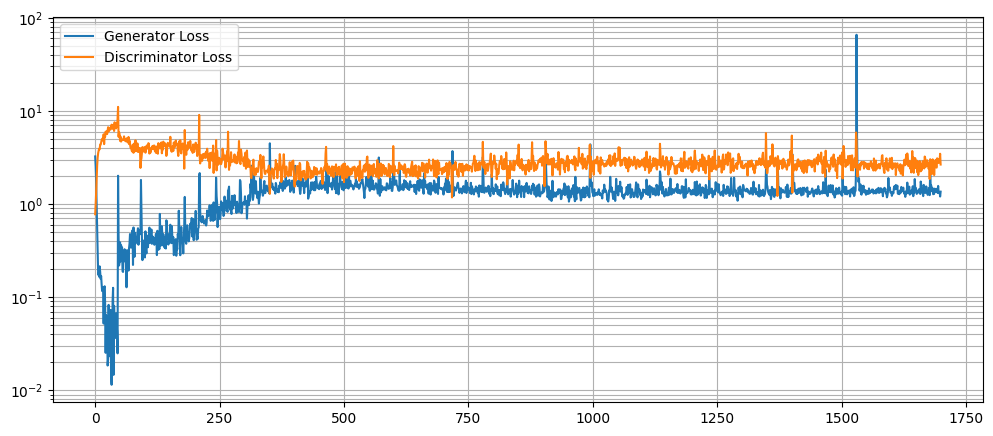

In [21]:
plt.figure(figsize=(12, 5))
plt.semilogy(g_loss, label='Generator Loss')
plt.semilogy(d_loss, label='Discriminator Loss')
plt.grid(True, 'both', 'both')
plt.legend()
plt.show()

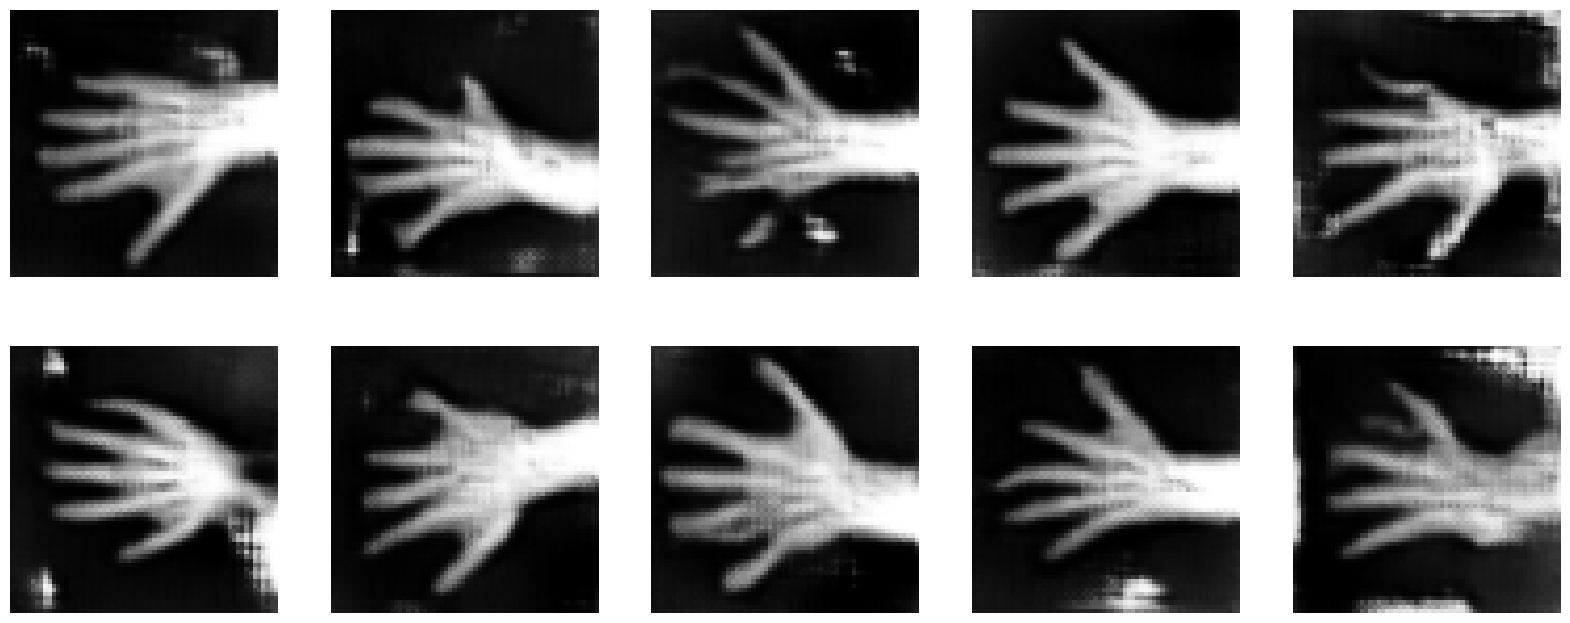

In [22]:
test_img_count = 10
test_latents = default_make_latent(test_img_count, latent_size).to(device)
fakes = gen_net(test_latents)

fig, axs = plt.subplots(2, (test_img_count // 2), figsize=(20, 8))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.axis('off')
    ax.imshow(fakes[i, 0].cpu().data.numpy(), cmap='gray')
